# Data Augmentation

### Leemos el dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import datetime
import random
#from tqdm.notebook import tqdm
from PIL import Image
from PIL import ImageEnhance
np.random.seed(1) #to have reproducible results 
pd.set_option('display.max_colwidth', None)

In [3]:
glob.glob('.//Dataset/*/*.jpg', recursive=True)[0]

'.//Dataset\\AntMan\\am1.jpg'

In [4]:
paths = glob.glob('.//Dataset/*/*.jpg', recursive=True)
paths[0]

'.//Dataset\\AntMan\\am1.jpg'

In [5]:
orig = np.array([np.asarray(Image.open(img)) for img in paths], dtype='object')
orig[0].shape

(267, 189, 3)

#### CV2

Código obtenido de: Tranleanh. (2022). Data-augmentation  
Recuperado de: https://github.com/tranleanh/data-augmentation/blob/main/data_augment_tool.py

In [26]:
import os
import cv2
import numpy as np
import random

def file_lines_to_list(path):
    '''
    ### Convert Lines in TXT File to List ###
    path: path to file
    '''
    with open(path) as f:
        content = f.readlines()
    content = [(x.strip()).split() for x in content]
    return content


def get_file_name(path):
    '''
    ### Get Filename of Filepath ###
    path: path to file
    '''
    basename = os.path.basename(path)
    onlyname = os.path.splitext(basename)[0]
    return onlyname

def colorjitter(img, cj_type="b"):
    '''
    ### Different Color Jitter ###
    img: image
    cj_type: {b: brightness, s: saturation, c: constast}
    '''
    if cj_type == "b":
        # value = random.randint(-50, 50)
        value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        if value >= 0:
            lim = 255 - value
            v[v > lim] = 255
            v[v <= lim] += value
        else:
            lim = np.absolute(value)
            v[v < lim] = 0
            v[v >= lim] -= np.absolute(value)

        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        return img
    
    elif cj_type == "s":
        # value = random.randint(-50, 50)
        value = np.random.choice(np.array([-50, -40, -30, 30, 40, 50]))
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        if value >= 0:
            lim = 255 - value
            s[s > lim] = 255
            s[s <= lim] += value
        else:
            lim = np.absolute(value)
            s[s < lim] = 0
            s[s >= lim] -= np.absolute(value)

        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        return img
    
    elif cj_type == "c":
        brightness = 10
        contrast = random.randint(40, 100)
        dummy = np.int16(img)
        dummy = dummy * (contrast/127+1) - contrast + brightness
        dummy = np.clip(dummy, 0, 255)
        img = np.uint8(dummy)
        return img


def noisy(img, noise_type="gauss"):
    '''
    ### Adding Noise ###
    img: image
    cj_type: {gauss: gaussian, sp: salt & pepper}
    '''
    if noise_type == "gauss":
        image=img.copy() 
        mean=0
        st=0.7
        gauss = np.random.normal(mean,st,image.shape)
        gauss = gauss.astype('uint8')
        image = cv2.add(image,gauss)
        return image
    
    elif noise_type == "sp":
        image=img.copy() 
        prob = 0.05
        if len(image.shape) == 2:
            black = 0
            white = 255            
        else:
            colorspace = image.shape[2]
            if colorspace == 3:  # RGB
                black = np.array([0, 0, 0], dtype='uint8')
                white = np.array([255, 255, 255], dtype='uint8')
            else:  # RGBA
                black = np.array([0, 0, 0, 255], dtype='uint8')
                white = np.array([255, 255, 255, 255], dtype='uint8')
        probs = np.random.random(image.shape[:2])
        image[probs < (prob / 2)] = black
        image[probs > 1 - (prob / 2)] = white
        return image


def filters(img, f_type = "blur"):
    '''
    ### Filtering ###
    img: image
    f_type: {blur: blur, gaussian: gaussian, median: median}
    '''
    if f_type == "blur":
        image=img.copy()
        fsize = 9
        return cv2.blur(image,(fsize,fsize))
    
    elif f_type == "gaussian":
        image=img.copy()
        fsize = 9
        return cv2.GaussianBlur(image, (fsize, fsize), 0)
    
    elif f_type == "median":
        image=img.copy()
        fsize = 9
        return cv2.medianBlur(image, fsize)

#### Imgaug

In [10]:
import imgaug as ia
import imgaug.augmenters as iaa

transform = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=(20,70))])
sa = cv2.imread(paths[0])
ti = transform(image=sa)
show_images([sa, ti])

AttributeError: 'list' object has no attribute 'shape'

<Figure size 1440x1440 with 0 Axes>

#### Resize al dataset:

In [7]:
sized_dataset = []
for img_path in paths:
       img_name = img_path.split('\\')[-1].split('.')[0]
       dir_path = f"ResizedDataset\\"+img_path.split('\\')[-2]
       if not os.path.exists(dir_path):
              os.makedirs(dir_path)
    
       # read image
       img = cv2.imread(img_path)
       height, width, channels = img.shape

       # create new image of desired size and color (blue) for padding
       new_image_height = 400
       new_image_width = 400

       if (width>new_image_width or height>new_image_height):
              #percent by which the image is resized
              scale_percent = 90
              #calculate the 50 percent of original dimensions
              height = img.shape[0]
              width = img.shape[1]

              while scale_percent > 0:
                     width = int(img.shape[1] * scale_percent / 100)
                     height = int(img.shape[0] * scale_percent / 100)
                     if height <= new_image_height and width <= new_image_width:    
                            break
                     scale_percent -= 1

              # dsize
              dsize = (width, height)
              # resize image
              img = cv2.resize(img, dsize)

       color = (255,0,0)
       result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)

       # compute center offset
       x_center = (new_image_width - width) // 2
       y_center = (new_image_height - height) // 2

       # copy img image into center of result image
       result[y_center:y_center+height, 
              x_center:x_center+width] = img

       # save result
       sized_dataset.append(result)
       #print(sized_dataset)
       print(np.asarray(sized_dataset).shape)
       cv2.imwrite(f"{dir_path}/{img_name}_r.jpg", result)

(1, 400, 400, 3)
(2, 400, 400, 3)
(3, 400, 400, 3)
(4, 400, 400, 3)
(5, 400, 400, 3)
(6, 400, 400, 3)
(7, 400, 400, 3)
(8, 400, 400, 3)
(9, 400, 400, 3)
(10, 400, 400, 3)
(11, 400, 400, 3)
(12, 400, 400, 3)
(13, 400, 400, 3)
(14, 400, 400, 3)
(15, 400, 400, 3)
(16, 400, 400, 3)
(17, 400, 400, 3)
(18, 400, 400, 3)
(19, 400, 400, 3)
(20, 400, 400, 3)
(21, 400, 400, 3)
(22, 400, 400, 3)
(23, 400, 400, 3)
(24, 400, 400, 3)
(25, 400, 400, 3)
(26, 400, 400, 3)
(27, 400, 400, 3)
(28, 400, 400, 3)
(29, 400, 400, 3)
(30, 400, 400, 3)
(31, 400, 400, 3)
(32, 400, 400, 3)
(33, 400, 400, 3)
(34, 400, 400, 3)
(35, 400, 400, 3)
(36, 400, 400, 3)
(37, 400, 400, 3)
(38, 400, 400, 3)
(39, 400, 400, 3)
(40, 400, 400, 3)
(41, 400, 400, 3)
(42, 400, 400, 3)
(43, 400, 400, 3)
(44, 400, 400, 3)
(45, 400, 400, 3)
(46, 400, 400, 3)
(47, 400, 400, 3)
(48, 400, 400, 3)
(49, 400, 400, 3)
(50, 400, 400, 3)
(51, 400, 400, 3)
(52, 400, 400, 3)
(53, 400, 400, 3)
(54, 400, 400, 3)
(55, 400, 400, 3)
(56, 400, 400, 3)
(

In [20]:

# Example batch of images
# The array has shape (32, 64, 64, 3) and dtype uint8
images = np.array(
    [ia.quokka(size=(64, 64)) for _ in range(32)],
    dtype=np.uint8
)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

images_aug = seq(images=sized_dataset)
print(images_aug)
for i in range(orig.size):
    img_name = paths[i].split('\\')[-1].split('.')[0]
    dir_path = f"AugmentedDataset\\"+paths[i].split('\\')[-2]
    
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    # read image
    cv2.imwrite(f"{dir_path}/{img_name}.jpg", images_aug[i])

[array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[199,  28,  28],
        [216,  45,  45],
        [211,  40,  40],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[200,  29,  29],
        [201,  30,  30],
        [197,  26,  26],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[185,  14,  14],
        [190,  19,  19],
        [199,  28,  28],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]

#### Scikit-Image

## Transformaciones con CV

In [ ]:
# Load Image and Its Annotation  
for img_path in paths:
    img_name = img_path.split('\\')[-1].split('.')[0]
    image = cv2.imread(img_path)

    #--------CSV Transformations--------#
    # Create Output Folder
    dir_path = f"AugmentedDataset"
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    # ColorJitter
    b_img = colorjitter(image, cj_type="b")
    s_img = colorjitter(image, cj_type="s")
    c_img = colorjitter(image, cj_type="c")
    cv2.imwrite(f"{dir_path}/{img_name}_brightness.jpg", b_img)
    cv2.imwrite(f"{dir_path}/{img_name}_saturation.jpg", s_img)
    cv2.imwrite(f"{dir_path}/{img_name}_contrast.jpg", c_img)

    # Adding Noise
    gaussn_img = noisy(image, noise_type="gauss")
    sp_img = noisy(image, noise_type="sp")
    cv2.imwrite(f"{dir_path}/{img_name}_gaussnoise.jpg", gaussn_img)
    cv2.imwrite(f"{dir_path}/{img_name}_spnoise.jpg", sp_img)

    # Filtering
    blur_img = filters(image, f_type = "blur")
    gaussf_img = filters(image, f_type = "gaussian")
    median_img = filters(image, f_type = "median")
    cv2.imwrite(f"{dir_path}/{img_name}_blur.jpg", blur_img)
    cv2.imwrite(f"{dir_path}/{img_name}_gaussblur.jpg", gaussf_img)
    cv2.imwrite(f"{dir_path}/{img_name}_median.jpg", median_img)
    
     #--------CSV Transformations--------#


    print("Generating Done!")

Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!
Generating Done!


KeyboardInterrupt: 

Lo siguiente es otro ejemplo de transformación que se puede hacer en una sola linea, so supongo es hacerle una función para que guarde las pics con diferentes funciones de cv2

In [ ]:
flip = [cv2.flip(img, np.random.choice([0, 1, -1])) if np.random.choice([0, 1]) else img for img in orig]

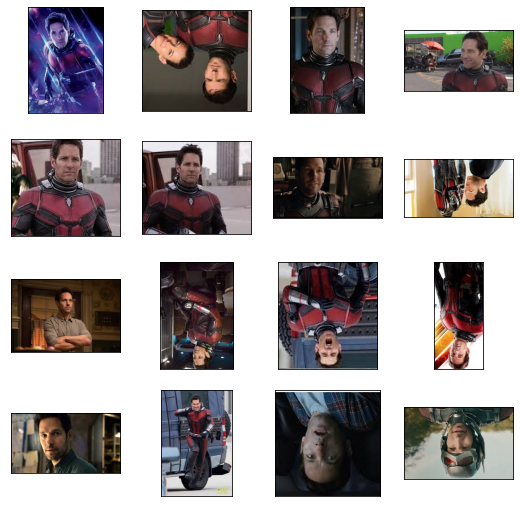

In [ ]:
plt.figure(figsize=(9,9))
i = 0
for img in flip[0:16]:
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    i += 1
plt.show()